# Introduction to the MIT Supercloud Dataset

This notebook is an introduction to working with the MIT Supercloud Dataset.  It introduces the types of data collected and ways to load, process, and plot the data.

Details of the dataset can be found in [The MIT Supercloud Dataset](https://arxiv.org/abs/2108.02037).

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Functions

In [2]:
def plot_time_series(df=None,
                     columns=None,
                     downsample=1,
                     samples_per_second=1,
                     title=None):
    
    """
    Plot CPU or GPU time series data
    
    Inputs:
    
        df: timeseries pandas dataframe
        columns: columns from timeseries to print
        downsample: number of samples to skip between each plotted sample
        samples_per_second: number of samples collected per second 
        title: string for plot title
        
    """

    # time index.  CPU time series are sampled every 10 seconds, GPU every tenth of a second
    t = np.linspace(0,df.shape[0]*(samples_per_second**-1),df.shape[0])[::downsample]

    # colors
    cm = plt.get_cmap('tab10')
    num_colors = df.columns.shape[0]
    colors = [cm(1.*i/num_colors) for i in range(num_colors)]

    # figure
    fig, axs = plt.subplots(3,3,figsize=(16,16))
    plt.suptitle(title,fontsize=14)

    # loop over columns to plot
    for ax,column,color in zip(axs.ravel(),columns,colors):
        plot_data = df[column].values[::downsample]
        ax.plot(t,plot_data,color=color)
        ax.tick_params(axis='x',rotation=-45)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel(column)
        ax.grid()
    plt.show()
    plt.close()

# Paths

In [3]:
# This path points to the root directory where the data was extracted
ROOT_PATH = 'PATH/TO/DATASET/LOCATION'

# The paths below point to specific files or directories
SCHEDULER_LOG_PATH = os.path.join(ROOT_PATH,'scheduler-log.csv') # slurm log csv
NODE_DATA_PATH = os.path.join(ROOT_PATH,'node-data.csv') # node data csv
CPU_DATA_PATH = os.path.join(ROOT_PATH,'cpu') # cpu time series directory
GPU_DATA_PATH = os.path.join(ROOT_PATH,'gpu') # gpu time series directory

# Slurm Log

In [4]:
# slurm log dataframe
scheduler_log_df = pd.read_csv(SCHEDULER_LOG_PATH)

In [5]:
# columns in slurm log dataframe
print('Columns for Scheduler log dataframe:\n')
print("\n".join([str(i) for i in scheduler_log_df.columns]))

Columns for Scheduler log dataframe:

id_job
id_array_job
id_array_task
id_user
kill_requid
nodes_alloc
nodelist
cpus_req
derived_ec
exit_code
gres_used
array_max_tasks
array_task_pending
constraints
flags
mem_req
partition
priority
state
timelimit
time_submit
time_eligible
time_start
time_end
time_suspended
track_steps
tres_alloc
tres_req
job_type


In [6]:
# job IDs in the slurm log
scheduler_log_job_ids = scheduler_log_df.id_job.unique()

# indices of gpu jobs
gpu_idx = scheduler_log_df.tres_req.apply(lambda x:str(x).find('1001')>0 or str(x).find('1002')>0)
scheduler_log_job_ids_gpu = np.unique(scheduler_log_df[gpu_idx].id_job.values)

print('There are {} jobs in the scheduler log, of which {} requested GPUs.'.format(scheduler_log_job_ids.shape[0],
                                                                                   scheduler_log_job_ids_gpu.shape[0]))

There are 395914 jobs in the scheduler log, of which 98176 requested GPUs.


# Node Data
Explore the data colleced from each compute node on the system.

In [7]:
# node data dataframe
node_data_df = pd.read_csv(NODE_DATA_PATH)

In [8]:
# # columns in slurm log dataframe
print('Columns for Node data dataframe:\n')
print("\n".join([str(i) for i in node_data_df.columns]))

Columns for Node data dataframe:

Node
Time
UserPIDCount
FSlatency
LoadAvg
MemoryFreeInactiveKB
LustreRPCTotals


In [9]:
node_data_df.head()

,Node,Time,UserPIDCount,FSlatency,LoadAvg,MemoryFreeInactiveKB,LustreRPCTotals
0,r7217787-n911952,1.614557e+09,91472915699408:11|1706828023724:15|65855960046...,0.0,29.24,371.0,26359.0
1,r4858666-n911952,1.614557e+09,66720169194922:40|,0.0,4.07,363.0,228.0
2,r2582019-n911952,1.614557e+09,22654259079669:47|,0.0,40.01,377.0,2006.0
3,r9040233-n911952,1.614557e+09,91472915699408:7|12886809117418:29|53679664603...,0.0,29.58,369.0,8289.0
4,r4229531-n911952,1.614557e+09,15914930715133:5|,0.0,0.26,390.0,227.0


# CPU Data (for single job)
Explore the CPU time series data.

In [10]:
# Load CPU data for a specific job 
cpu_job_id = scheduler_log_job_ids[0] 

# Load summary and time series csv files into dataframes for specific job
for root, _, files in os.walk(CPU_DATA_PATH,topdown=False):
    for csv_file in files:
        if str(cpu_job_id) in csv_file:
            if 'summary' in csv_file:
                cpu_summary_path = os.path.join(root,csv_file)
            else:
                cpu_timeseries_path = os.path.join(root,csv_file)
        
# read csv into dataframe
cpu_summary_df = pd.read_csv(cpu_summary_path)
cpu_df = pd.read_csv(cpu_timeseries_path)

# columns for summary dataframe
print('###################################')
print('# Columns for CPU summary dataframe')
print('###################################\n')
print("\n".join([str(i) for i in cpu_summary_df.columns]))

# columns for timeseries dataframe
print('\n######################################')
print('# Columns for CPU timeseries dataframe')
print('######################################\n')
print("\n".join([str(i) for i in cpu_df.columns]))

print('\nThe CPU time series for job_id {} has {} samples.'.format(cpu_job_id,
                                                                   cpu_df.shape[0]))

###################################
# Columns for CPU summary dataframe
###################################

Step
Node
Series
ElapsedTime
Min_EpochTime
Max_EpochTime
Sum_EpochTime
Avg_EpochTime
Min_CPUFrequency
Max_CPUFrequency
Sum_CPUFrequency
Avg_CPUFrequency
Min_CPUTime
Max_CPUTime
Sum_CPUTime
Avg_CPUTime
Min_CPUUtilization
Max_CPUUtilization
Sum_CPUUtilization
Avg_CPUUtilization
Min_RSS
Max_RSS
Sum_RSS
Avg_RSS
Min_VMSize
Max_VMSize
Sum_VMSize
Avg_VMSize
Min_Pages
Max_Pages
Sum_Pages
Avg_Pages
Min_ReadMB
Max_ReadMB
Sum_ReadMB
Avg_ReadMB
Min_WriteMB
Max_WriteMB
Sum_WriteMB
Avg_WriteMB

######################################
# Columns for CPU timeseries dataframe
######################################

Step
Node
Series
ElapsedTime
EpochTime
CPUFrequency
CPUTime
CPUUtilization
RSS
VMSize
Pages
ReadMB
WriteMB

The CPU time series for job_id 82691694838059 has 62 samples.


## Plot CPU time series

In [11]:
# Be sure to only select Step values equal to 'batch'
cpu_summary_df = cpu_summary_df[cpu_summary_df.Step=='batch']
cpu_df = cpu_df[cpu_df.Step=='batch']

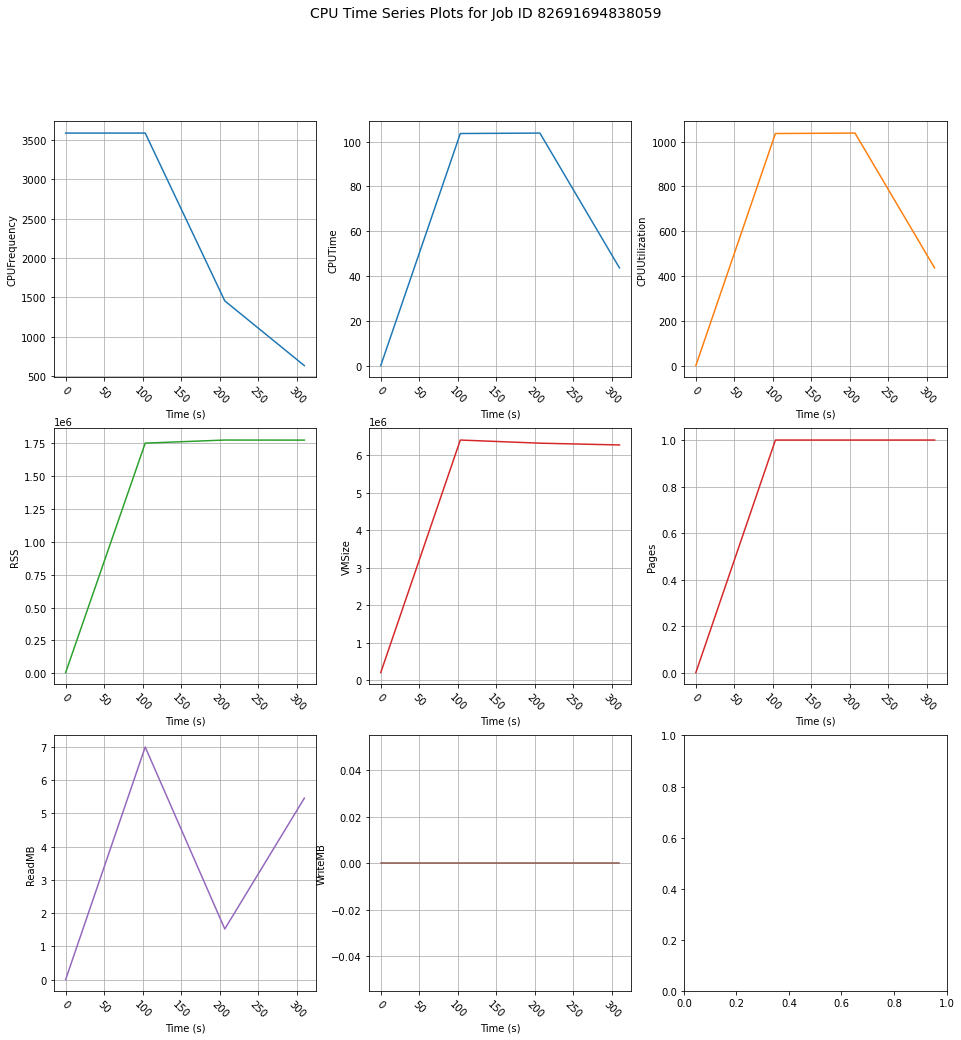

In [12]:
cpu_plot_columns = [
    'CPUFrequency', 
    'CPUTime', 
    'CPUUtilization', 
    'RSS', 
    'VMSize', 
    'Pages', 
    'ReadMB', 
    'WriteMB'
]

# downsample step size for plots
cpu_downsample = 10

plot_time_series(df=cpu_df,
                 columns=cpu_plot_columns,
                 downsample=cpu_downsample,
                 samples_per_second=0.1,
                 title='CPU Time Series Plots for Job ID {}'.format(cpu_job_id))

# GPU Data (for a single job)
Explore the GPU time series data.

In [13]:
# Load GPU data for a specific job 
gpu_job_id = scheduler_log_job_ids_gpu[0]

# Load summary and time series csv files into dataframes for specific job
for root, _, files in os.walk(GPU_DATA_PATH,topdown=False):
   
   for csv_file in files:
   
        if str(gpu_job_id) in csv_file:

            gpu_timeseries_path = os.path.join(root,csv_file)
        
# read csv into dataframe
gpu_df = pd.read_csv(gpu_timeseries_path)

# columns for timeseries dataframe
print('\n######################################')
print('# Columns for GPU timeseries dataframe')
print('######################################\n')
print("\n".join([str(i) for i in gpu_df.columns]))

print('\nThe GPU time series for job_id {} has {} samples.'.format(gpu_job_id,
                                                                   gpu_df.shape[0]))


######################################
# Columns for GPU timeseries dataframe
######################################

timestamp
gpu_index
utilization_gpu_pct
utilization_memory_pct
memory_free_MiB
memory_used_MiB
temperature_gpu
temperature_memory
power_draw_W
pcie_link_width_current

The GPU time series for job_id 409499185 has 23014 samples.


## Extract GPU time series by GPU index

In [14]:
# Since a single job can request multiple GPUs we need to separate the GPU df loaded above by gpu_index.
# It may be the case that only a single GPU was requested but for generality we will create a new dictionary
# structure here with each gpu index acting as the key and corresponding GPU's time series as the value.

# number of GPUs in time series, for given job
print('There were {} GPU(s) requested for the current job'.format(gpu_df.gpu_index.unique().shape[0]))

# separate GPU time series
gpu_df_dict = dict()

for gpu_index in gpu_df.gpu_index.unique():
    
    gpu_df_dict[gpu_index] = gpu_df[gpu_df.gpu_index==gpu_index]

There were 1 GPU(s) requested for the current job


## Plot GPU time series

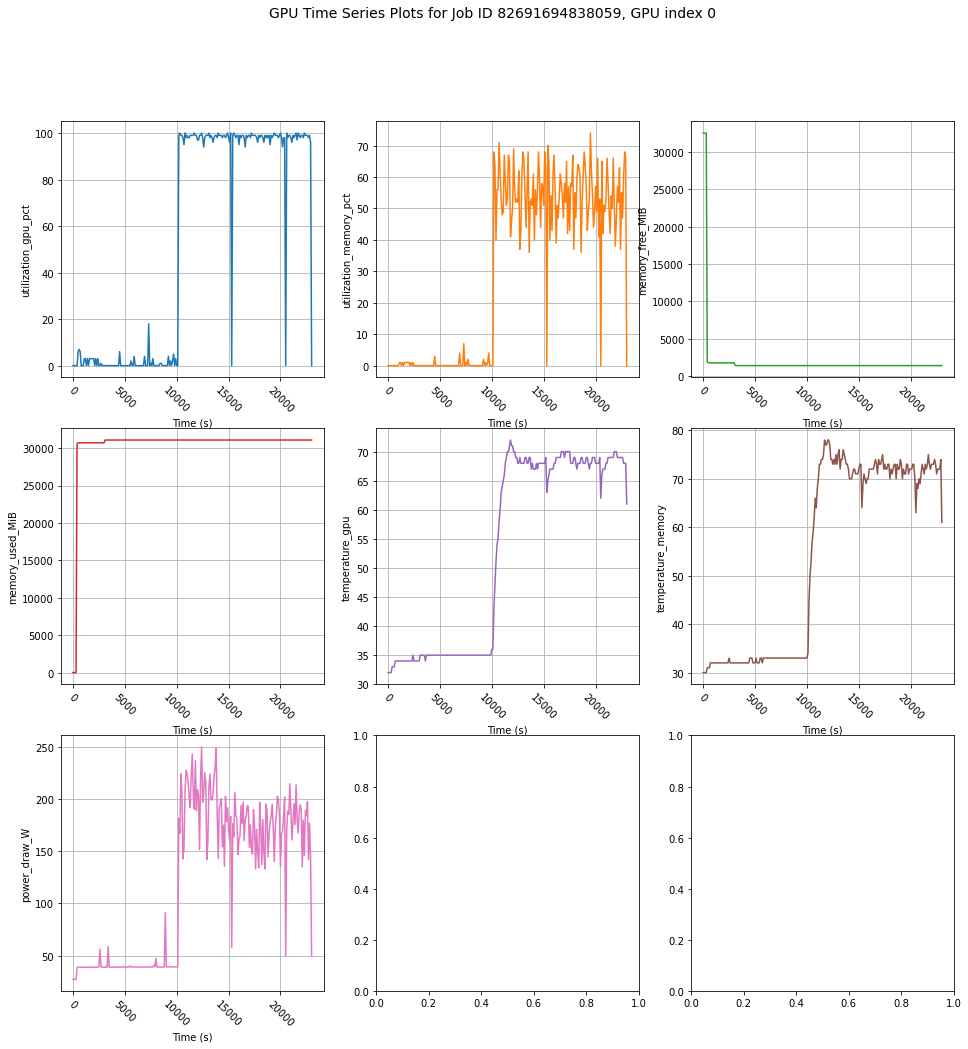

In [15]:
gpu_plot_columns = [
    'utilization_gpu_pct',
    'utilization_memory_pct',
    'memory_free_MiB',
    'memory_used_MiB',
    'temperature_gpu',
    'temperature_memory',
    'power_draw_W',
]

# downsample step size for plots
gpu_downsample = 100

gpu_index = 0

plot_time_series(df=gpu_df_dict[gpu_index],
                 columns=gpu_plot_columns,
                 downsample=gpu_downsample,
                 title='GPU Time Series Plots for Job ID {}, GPU index {}'.format(cpu_job_id,gpu_index))